# Configuration

### Package Imports

In [1]:
from google.cloud import storage
import copy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAvgPool2D, concatenate
from tensorflow.keras.layers import Add, ZeroPadding2D, AveragePooling2D, GaussianNoise, SeparableConv2D, Concatenate, LeakyReLU, Reshape, Lambda, Permute
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from skimage.transform import resize
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm
import numpy as np
import pickle
from PIL import Image
import os
import random
from io import BytesIO
import io

### Directory Paths

In [2]:
config_bucket_name = 'open_images_v6_source_files'
config_prefix_name = 'yolo_example'
config_weight_path = f'{config_bucket_name}'
model_save_path = 'model_save_dir/'
model_save_name = 'yolo_detector.hdf5'
dict_list_save_name = 'object_dict_list.txt'

### Model and Data Processing

In [41]:
#LABELS = ['Television', 'Couch', 'Coffee table']
#IMAGE_H, IMAGE_W = 256, 256
#GRID_H,  GRID_W  = 8, 8
#BOX              = 5
#CLASS            = len(LABELS)
#CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
#OBJ_THRESHOLD    = 0.3
#NMS_THRESHOLD    = 0.3
#ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
#NO_OBJECT_SCALE  = 1.0
#OBJECT_SCALE     = 5.0
#COORD_SCALE      = 1.0
#CLASS_SCALE      = 1.0
#BATCH_SIZE       = 16
#WARM_UP_BATCHES  = 0
#TRUE_BOX_BUFFER  = 50

generator_config = {
    'IMAGE_H' : 256, 
    'IMAGE_W' : 256,
    'GRID_H' : 8,  
    'GRID_W' : 8,
    'BOX' : 5,
    'LABELS' : ['Television', 'Couch', 'Coffee table'],
    'CLASS' : len(['Television', 'Couch', 'Coffee table']),
    'ANCHORS' : [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828],
    'BATCH_SIZE' : 1,
    'TRUE_BOX_BUFFER' : 50,
    'LAMBDA_NO_OBJECT' : 1.0,
    'LAMBDA_OBJECT':  5.0,
    'LAMBDA_COORD' : 1.0,
    'LAMBDA_CLASS' : 1.0
}

# Define Functions

### Google Cloud Storage Reading

In [9]:
def get_storage_file_names(prefix = '', bucket_name = config_bucket_name):
    """
    Get list of file names in a Google Cloud Storage bucket given a prefix (folder path)
    """
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    bucket_files = [f for f in bucket.list_blobs()]
    file_list = list(bucket.list_blobs(prefix = prefix))
    file_names = [str(f).split(', ')[1] for f in file_list]
    return file_names

def read_gcs_pickle_file(file_name, bucket_name = config_bucket_name):
    """
    Read .pkl file from Google Cloud Storage bucket
    """
    client = storage.Client()
    bucket = client.get_bucket(config_bucket_name)
    blob = bucket.get_blob(file_name)
    blob = pickle.load(BytesIO(bytearray(blob.download_as_string())))
    return blob

def read_gcs_image_file(file_name, bucket_name = config_bucket_name):
    """
    Read image file from Google Cloud Storage bucket
    """
    client = storage.Client()
    bucket = client.get_bucket(config_bucket_name)
    blob = storage.Blob(file_name, bucket)
    blob = blob.download_as_string()
    blob = io.BytesIO(blob)
    img = np.asarray(Image.open(blob))
    return img

class ImageReader(object):
    def __init__(self,
                 IMAGE_H = generator_config.get('IMAGE_H'),
                 IMAGE_W = generator_config.get('IMAGE_W'),
                 bucket_name = config_bucket_name):
        """
        Read & resize images stored in Google Cloud Storage bucket
        and return bounding box information given a dictionary with the following format:
            {'filename': 'outer_folder/subfolder/image_name.jpg',
             'height':   333,
             'width':    500,
             'object': [{'name': 'bird', 'xmax': 318, 'xmin': 284, 'ymax': 184, 'ymin': 100},
                        {'name': 'bird',  'xmax': 198, 'xmin': 112, 'ymax': 209, 'ymin': 146}]}
        Args:
            IMAGE_H (int): image height
            IMAGE_W (int): image width
            bucket_name (str): name of google cloud storage bucket
        """
        self.IMAGE_H = IMAGE_H
        self.IMAGE_W = IMAGE_W
        self.bucket_name = bucket_name
    
    def fit(self,train_instance):
        if not isinstance(train_instance,dict):
            train_instance = {'filename':train_instance}
        image_name = train_instance['filename']
        image = read_gcs_image_file(file_name = image_name, bucket_name = self.bucket_name)
        h, w, c = image.shape
        image = image[:,:,::-1]
        image = resize(image, (self.IMAGE_H, self.IMAGE_W))  
        if 'object' in train_instance.keys():
            all_objs = copy.deepcopy(train_instance['object'])     
            for obj in all_objs:
                for attr in ['xmin', 'xmax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_W) / w)
                    obj[attr] = max(min(obj[attr], self.IMAGE_W), 0)

                for attr in ['ymin', 'ymax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_H) / h)
                    obj[attr] = max(min(obj[attr], self.IMAGE_H), 0)
        else:
            return image
        return image, all_objs

    

class ImageReaderLoaded(object):
    def __init__(self,
                 filename_image_dict,
                 IMAGE_H = generator_config.get('IMAGE_H'),
                 IMAGE_W = generator_config.get('IMAGE_W'),
                 bucket_name = config_bucket_name):
        """
        Read & resize images stored in Google Cloud Storage bucket
        and return bounding box information given a dictionary with the following format:
            {'filename': 'outer_folder/subfolder/image_name.jpg',
             'height':   333,
             'width':    500,
             'object': [{'name': 'bird', 'xmax': 318, 'xmin': 284, 'ymax': 184, 'ymin': 100},
                        {'name': 'bird',  'xmax': 198, 'xmin': 112, 'ymax': 209, 'ymin': 146}]}
        Args:
            IMAGE_H (int): image height
            IMAGE_W (int): image width
            bucket_name (str): name of google cloud storage bucket
        """
        self.filename_image_dict = filename_image_dict
        self.IMAGE_H = IMAGE_H
        self.IMAGE_W = IMAGE_W
        self.bucket_name = bucket_name
    
    def fit(self,train_instance):
        if not isinstance(train_instance,dict):
            train_instance = {'filename':train_instance}
        image_name = train_instance['filename']
        image = filename_image_dict.get(image_name)
        #image = read_gcs_image_file(file_name = image_name, bucket_name = self.bucket_name)
        h, w, c = image.shape
        image = image[:,:,::-1]
        image = resize(image, (self.IMAGE_H, self.IMAGE_W))  
        if 'object' in train_instance.keys():
            all_objs = copy.deepcopy(train_instance['object'])     
            for obj in all_objs:
                for attr in ['xmin', 'xmax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_W) / w)
                    obj[attr] = max(min(obj[attr], self.IMAGE_W), 0)

                for attr in ['ymin', 'ymax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_H) / h)
                    obj[attr] = max(min(obj[attr], self.IMAGE_H), 0)
        else:
            return image
        return image, all_objs

### Image Manipulation Functions

In [10]:
def normalize(image):
    """
    Normalize numpy image array by dividing floats by 255.
    Args:
        image (np.array): 3d numpy image array
    """
    return image / 255.



class BestAnchorBoxFinder(object):
    def __init__(self, ANCHORS = generator_config.get('ANCHORS')):
        """
        Given a fixed set of initial anchors, find anchor boxes that maximize
        intersection over union (IOU)
        Args:
            ANCHORS (np.array): array of floats (must be even number length)
        """
        self.anchors = [BoundBox(0, 0, ANCHORS[2*i], ANCHORS[2*i+1]) 
                        for i in range(int(len(ANCHORS)//2))]
        
    def _interval_overlap(self,interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2,x4) - x1
        else:
            if x2 < x3:
                 return 0
            else:
                return min(x2,x4) - x3  

    def bbox_iou(self,box1, box2):
        intersect_w = self._interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
        intersect_h = self._interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  
        intersect = intersect_w * intersect_h
        w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
        w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
        union = w1*h1 + w2*h2 - intersect
        return float(intersect) / union
    
    def find(self,center_w, center_h):
        best_anchor = -1
        max_iou     = -1
        shifted_box = BoundBox(0, 0,center_w, center_h)
        for i in range(len(self.anchors)):
            anchor = self.anchors[i]
            iou    = self.bbox_iou(shifted_box, anchor)
            if max_iou < iou:
                best_anchor = i
                max_iou     = iou
        return(best_anchor,max_iou)
    
    
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, confidence=None,classes=None):
        """
        Returns labels and confidence score given a list of classes
        and vector of predicted probabilities
        Args:
            xmin (float): minimum x-axis value in bounding box
            ymin (float): minimum y-axis value in bounding box
            xmax (float): maximum x-axis value in bounding box
            ymax (float): maximum y-axis value in bounding box
        
        """
        self.xmin, self.ymin = xmin, ymin
        self.xmax, self.ymax = xmax, ymax
        self.confidence      = confidence
        self.set_class(classes)
        
    def set_class(self,classes):
        self.classes = classes
        self.label   = np.argmax(self.classes) 
        
    def get_label(self):  
        return(self.label)
    
    def get_score(self):
        return(self.classes[self.label])
    
    

def rescale_centerxy(obj, config = generator_config):
    """
    Find centermost point within a grid overlaid on numpy array
    Args:
        obj (dict): dictionary with keys 'xmin', 'xmax', 'ymin', 'ymax'
        config (dict): dictionary with keys 'IMAGE_W', 'GRID_W', 'IMAGE_H' and 'GRID_H'
    Returns:
        tuple
    """
    center_x = .5 * (obj['xmin'] + obj['xmax'])
    center_x = center_x / (float(config['IMAGE_W']) / config['GRID_W'])
    center_y = .5 * (obj['ymin'] + obj['ymax'])
    center_y = center_y / (float(config['IMAGE_H']) / config['GRID_H'])
    return (center_x, center_y)

def rescale_centerwh(obj, config = generator_config):
    """
    Find centermost point within a grid overlaid on numpy array
    Args:
        obj (dict): dictionary with keys 'xmin', 'xmax', 'ymin', 'ymax'
        config (dict): dictionary with keys 'IMAGE_W', 'GRID_W', 'IMAGE_H' and 'GRID_H'
    Returns:
        tuple
    """
    center_w = (obj['xmax'] - obj['xmin']) / (float(config['IMAGE_W']) / config['GRID_W']) 
    center_h = (obj['ymax'] - obj['ymin']) / (float(config['IMAGE_H']) / config['GRID_H']) 
    return(center_w, center_h)

### Functions that still need clean up

In [42]:
class SimpleBatchGenerator(Sequence):
    def __init__(self, images, config = generator_config, shuffle = True):
        """
        Batch generator class to feed minibatches into Keras Model() object
        Args:
            config : dictionary with keys:
                'IMAGE_H', 'IMAGE_W', 'GRID_H', 'GRID_W', 'LABELS',
                'ANCHORS', 'BATCH_SIZE', 'TRUE_BOX_BUFFER'
        """
        self.config = config
        self.config["BOX"] = int(len(self.config['ANCHORS'])/2)
        self.config["CLASS"] = len(self.config['LABELS'])
        self.images = images
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(config['ANCHORS'])
        self.imageReader = ImageReader(config['IMAGE_H'],config['IMAGE_W'])
        self.shuffle = shuffle
        if self.shuffle: 
            np.random.shuffle(self.images)
            
    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))  
    
    def __getitem__(self, idx):
        '''
        == input == 
        
        idx : non-negative integer value e.g., 0
        
        == output ==
        
        x_batch: The numpy array of shape  (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels).
            
            x_batch[iframe,:,:,:] contains a iframeth frame of size  (IMAGE_H,IMAGE_W).
            
        y_batch:

            The numpy array of shape  (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes). 
            BOX = The number of anchor boxes.

            y_batch[iframe,igrid_h,igrid_w,ianchor,:4] contains (center_x,center_y,center_w,center_h) 
            of ianchorth anchor at  grid cell=(igrid_h,igrid_w) if the object exists in 
            this (grid cell, anchor) pair, else they simply contain 0.

            y_batch[iframe,igrid_h,igrid_w,ianchor,4] contains 1 if the object exists in this 
            (grid cell, anchor) pair, else it contains 0.

            y_batch[iframe,igrid_h,igrid_w,ianchor,5 + iclass] contains 1 if the iclass^th 
            class object exists in this (grid cell, anchor) pair, else it contains 0.


        b_batch:

            The numpy array of shape (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4).

            b_batch[iframe,1,1,1,ibuffer,ianchor,:] contains ibufferth object's 
            (center_x,center_y,center_w,center_h) in iframeth frame.

            If ibuffer > N objects in iframeth frame, then the values are simply 0.

            TRUE_BOX_BUFFER has to be some large number, so that the frame with the 
            biggest number of objects can also record all objects.

            The order of the objects do not matter.

            This is just a hack to easily calculate loss. 
        
        '''
        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0
        
        ## prepare empty storage space: this will be output
        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))                         # input images
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))   # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))                # desired network output

        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.imageReader.fit(train_instance)
            
            # construct output from object's x, y, w, h
            true_box_index = 0
            
            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x, center_y = rescale_centerxy(obj,self.config)
                    
                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx  = self.config['LABELS'].index(obj['name'])
                        center_w, center_h = rescale_centerwh(obj,self.config)
                        box = [center_x, center_y, center_w, center_h]
                        best_anchor,max_iou = self.bestAnchorBoxFinder.find(center_w, center_h)
                                
                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        # it could happen that the same grid cell contain 2 similar shape objects
                        # as a result the same anchor box is selected as the best anchor box by the multiple objects
                        # in such ase, the object is over written
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box # center_x, center_y, w, h
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1. # ground truth confidence is 1
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1 # class probability of the object
                        
                        # assign the true box to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            x_batch[instance_count] = img
            # increase instance counter in current batch
            instance_count += 1  
        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: 
            np.random.shuffle(self.images)
            
            
class SimpleBatchGeneratorLoaded(Sequence):
    def __init__(self, images, filename_image_dict, config = generator_config, shuffle = True):
        """
        Batch generator class to feed minibatches into Keras Model() object
        Args:
            config : dictionary with keys:
                'IMAGE_H', 'IMAGE_W', 'GRID_H', 'GRID_W', 'LABELS',
                'ANCHORS', 'BATCH_SIZE', 'TRUE_BOX_BUFFER'
        """
        self.config = config
        self.config["BOX"] = int(len(self.config['ANCHORS'])/2)
        self.config["CLASS"] = len(self.config['LABELS'])
        self.images = images
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(config['ANCHORS'])
        self.imageReader = ImageReaderLoaded(filename_image_dict, config['IMAGE_H'],config['IMAGE_W'])
        self.shuffle = shuffle
        if self.shuffle: 
            np.random.shuffle(self.images)
            
    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))  
    
    def __getitem__(self, idx):
        '''
        == input == 
        
        idx : non-negative integer value e.g., 0
        
        == output ==
        
        x_batch: The numpy array of shape  (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels).
            
            x_batch[iframe,:,:,:] contains a iframeth frame of size  (IMAGE_H,IMAGE_W).
            
        y_batch:

            The numpy array of shape  (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes). 
            BOX = The number of anchor boxes.

            y_batch[iframe,igrid_h,igrid_w,ianchor,:4] contains (center_x,center_y,center_w,center_h) 
            of ianchorth anchor at  grid cell=(igrid_h,igrid_w) if the object exists in 
            this (grid cell, anchor) pair, else they simply contain 0.

            y_batch[iframe,igrid_h,igrid_w,ianchor,4] contains 1 if the object exists in this 
            (grid cell, anchor) pair, else it contains 0.

            y_batch[iframe,igrid_h,igrid_w,ianchor,5 + iclass] contains 1 if the iclass^th 
            class object exists in this (grid cell, anchor) pair, else it contains 0.


        b_batch:

            The numpy array of shape (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4).

            b_batch[iframe,1,1,1,ibuffer,ianchor,:] contains ibufferth object's 
            (center_x,center_y,center_w,center_h) in iframeth frame.

            If ibuffer > N objects in iframeth frame, then the values are simply 0.

            TRUE_BOX_BUFFER has to be some large number, so that the frame with the 
            biggest number of objects can also record all objects.

            The order of the objects do not matter.

            This is just a hack to easily calculate loss. 
        
        '''
        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0
        
        ## prepare empty storage space: this will be output
        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))                         # input images
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))   # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))                # desired network output

        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.imageReader.fit(train_instance)
            
            # construct output from object's x, y, w, h
            true_box_index = 0
            
            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x, center_y = rescale_centerxy(obj,self.config)
                    
                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx  = self.config['LABELS'].index(obj['name'])
                        center_w, center_h = rescale_centerwh(obj,self.config)
                        box = [center_x, center_y, center_w, center_h]
                        best_anchor,max_iou = self.bestAnchorBoxFinder.find(center_w, center_h)
                                
                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        # it could happen that the same grid cell contain 2 similar shape objects
                        # as a result the same anchor box is selected as the best anchor box by the multiple objects
                        # in such ase, the object is over written
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box # center_x, center_y, w, h
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1. # ground truth confidence is 1
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1 # class probability of the object
                        
                        # assign the true box to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            x_batch[instance_count] = img
            # increase instance counter in current batch
            instance_count += 1  
        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: 
            np.random.shuffle(self.images)


"""
def check_object_in_grid_anchor_pair(irow):
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    assert len(class_nm) == 1
                    print("igrid_h={:02.0f},igrid_w={:02.0f},iAnchor={:02.0f}, {}".format(
                        igrid_h,igrid_w,ianchor,class_nm[0]))
"""       
                    
def space_to_depth_x2(x):
    """
    Function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
    """
    return tf.nn.space_to_depth(x, block_size=2)
            
class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4



def get_cell_grid(GRID_W = generator_config.get('GRID_W'),
                  GRID_H = generator_config.get('GRID_H'),
                  BATCH_SIZE = generator_config.get('BATCH_SIZE'),
                  BOX = generator_config.get('BOX')): 
    '''
    Helper function to assure that the bounding box x and y are in the grid cell scale
    == output == 
    for any i=0,1..,batch size - 1
    output[i,5,3,:,:] = array([[3., 5.],
                               [3., 5.],
                               [3., 5.]], dtype=float32)
    '''
    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))  
    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, BOX, 1])
    return(cell_grid) 



def adjust_scale_prediction(y_pred, cell_grid,
                            ANCHORS = generator_config.get('ANCHORS'),
                            BOX = generator_config.get('BOX')):    
    """
        Adjust prediction
        
        == input ==
        
        y_pred : takes any real values
                 tensor of shape = (N batch, NGrid h, NGrid w, NAnchor, 4 + 1 + N class)
        
        ANCHORS : list containing width and height specializaiton of anchor box
        == output ==
        
        pred_box_xy : shape = (N batch, N grid x, N grid y, N anchor, 2), contianing [center_y, center_x] rangining [0,0]x[grid_H-1,grid_W-1]
          pred_box_xy[irow,igrid_h,igrid_w,ianchor,0] =  center_x
          pred_box_xy[irow,igrid_h,igrid_w,ianchor,1] =  center_1
          
          calculation process:
          tf.sigmoid(y_pred[...,:2]) : takes values between 0 and 1
          tf.sigmoid(y_pred[...,:2]) + cell_grid : takes values between 0 and grid_W - 1 for x coordinate 
                                                   takes values between 0 and grid_H - 1 for y coordinate 
                                                   
        pred_Box_wh : shape = (N batch, N grid h, N grid w, N anchor, 2), containing width and height, rangining [0,0]x[grid_H-1,grid_W-1]
        pred_box_conf : shape = (N batch, N grid h, N grid w, N anchor, 1), containing confidence to range between 0 and 1
        pred_box_class : shape = (N batch, N grid h, N grid w, N anchor, N class), containing 
    """
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS,[1,1,1,BOX,2])
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    pred_box_class = y_pred[..., 5:]
    return(pred_box_xy,pred_box_wh,pred_box_conf,pred_box_class)


def extract_ground_truth(y_true):    
    true_box_xy    = y_true[..., 0:2] # bounding box x, y coordinate in grid cell scale 
    true_box_wh    = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    true_box_conf  = y_true[...,4]    # confidence 
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    return(true_box_xy, true_box_wh, true_box_conf, true_box_class)



def calc_loss_xywh(true_box_conf, COORD_SCALE, true_box_xy, pred_box_xy, true_box_wh, pred_box_wh,
                   LAMBDA_COORD = generator_config.get('LAMBDA_COORD')): 
    coord_mask  = tf.expand_dims(true_box_conf, axis=-1) * LAMBDA_COORD 
    nb_coord_box = tf.reduce_sum(tf.cast(coord_mask > 0.0, tf.float32))

    loss_xy = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh) * coord_mask) / (nb_coord_box + 1e-6) / 2.

    return (loss_xy + loss_wh, coord_mask)


def calc_loss_class(true_box_conf,CLASS_SCALE, true_box_class,pred_box_class):
    '''
    == input ==    
    true_box_conf  : tensor of shape (N batch, N grid h, N grid w, N anchor)
    true_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor), containing class index
    pred_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor, N class)
    CLASS_SCALE    : 1.0
    
    == output ==  
    class_mask
    if object exists in this (grid_cell, anchor) pair and the class object receive nonzero weight
        class_mask[iframe,igridy,igridx,ianchor] = 1 
    else: 
        0 
    '''   
    class_mask   = true_box_conf  * CLASS_SCALE ## L_{i,j}^obj * lambda_class
    
    nb_class_box = tf.reduce_sum(tf.cast(class_mask > 0.0, tf.float32))
    loss_class   = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = true_box_class, 
                                                                  logits = pred_box_class)
    loss_class   = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)   
    return(loss_class)


def get_intersect_area(true_xy,true_wh, pred_xy,pred_wh):
    '''
    == INPUT ==
    true_xy,pred_xy, true_wh and pred_wh must have the same shape length

    p1 : pred_mins = (px1,py1)
    p2 : pred_maxs = (px2,py2)
    t1 : true_mins = (tx1,ty1) 
    t2 : true_maxs = (tx2,ty2) 
                 p1______________________ 
                 |      t1___________   |
                 |       |           |  |
                 |_______|___________|__|p2 
                         |           |rmax
                         |___________|
                                      t2
    intersect_mins : rmin = t1  = (tx1,ty1)
    intersect_maxs : rmax = (rmaxx,rmaxy)
    intersect_wh   : (rmaxx - tx1, rmaxy - ty1)
        
    '''
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)    
    return(iou_scores)

def calc_IOU_pred_true_assigned(true_box_conf, true_box_xy, true_box_wh, pred_box_xy,  pred_box_wh):
    ''' 
    == input ==
    
    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor )
    true_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    true_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
        
    == output ==
    
    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor)
    
    true_box_conf value depends on the predicted values 
    true_box_conf = IOU_{true,pred} if objecte exist in this anchor else 0
    '''
    iou_scores =  get_intersect_area(true_box_xy,true_box_wh, pred_box_xy,pred_box_wh)
    true_box_conf_IOU = iou_scores * true_box_conf
    return(true_box_conf_IOU)
    
    
def calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes):   
    '''
    == input ==
    pred_box_xy : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    pred_box_wh : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    true_boxes  : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    
    == output == 
    
    best_ious
    
    for each iframe,
        best_ious[iframe,igridy,igridx,ianchor] contains
        
        the IOU of the object that is most likely included (or best fitted) 
        within the bounded box recorded in (grid_cell, anchor) pair
        
        NOTE: a same object may be contained in multiple (grid_cell, anchor) pair
              from best_ious, you cannot tell how may actual objects are captured as the "best" object
    '''
    true_xy = true_boxes[..., 0:2]           # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)
    true_wh = true_boxes[..., 2:4]           # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)
    
    pred_xy = tf.expand_dims(pred_box_xy, 4) # (N batch, N grid_h, N grid_w, N anchor, 1, 2)
    pred_wh = tf.expand_dims(pred_box_wh, 4) # (N batch, N grid_h, N grid_w, N anchor, 1, 2)
    
    iou_scores  =  get_intersect_area(true_xy,
                                      true_wh,
                                      pred_xy,
                                      pred_wh) # (N batch, N grid_h, N grid_w, N anchor, 50)   

    best_ious = tf.reduce_max(iou_scores, axis=4) # (N batch, N grid_h, N grid_w, N anchor)
    return(best_ious)
    
    
def get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,
                  LAMBDA_NO_OBJECT = generator_config.get('LAMBDA_NO_OBJECT'),
                  LAMBDA_OBJECT = generator_config.get('LAMBDA_OBJECT')):    
    '''
    == input == 
    
    best_ious           : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf       : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU   : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    LAMBDA_NO_OBJECT    : 1.0
    LAMBDA_OBJECT       : 5.0
    
    == output ==
    conf_mask : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    
    conf_mask[iframe, igridy, igridx, ianchor] = 0
               when there is no object assigned in (grid cell, anchor) pair and the region seems useless i.e. 
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has no object that has IoU > 0.6
               
    conf_mask[iframe, igridy, igridx, ianchor] =  NO_OBJECT_SCALE
               when there is no object assigned in (grid cell, anchor) pair but region seems to include some object
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has some object that has IoU > 0.6
               
    conf_mask[iframe, igridy, igridx, ianchor] =  OBJECT_SCALE
              when there is an object in (grid cell, anchor) pair        
    '''

    conf_mask = tf.cast(best_ious < 0.6, tf.float32) * (1 - true_box_conf) * LAMBDA_NO_OBJECT
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + true_box_conf_IOU * LAMBDA_OBJECT
    return(conf_mask)
    
    
def calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf):  
    '''
    == input ==
    
    conf_mask         : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    pred_box_conf     : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    '''
    # the number of (grid cell, anchor) pair that has an assigned object or
    # that has no assigned object but some objects may be in bounding box.
    # N conf
    nb_conf_box  = tf.reduce_sum(tf.cast(conf_mask  > 0.0, tf.float32))
    loss_conf    = tf.reduce_sum(tf.square(true_box_conf_IOU-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    return(loss_conf)


def custom_loss(y_true, y_pred,
                GRID_W = generator_config.get('GRID_W'),
                GRID_H = generator_config.get('GRID_H'),
                BATCH_SIZE = generator_config.get('BATCH_SIZE'),
                BOX = generator_config.get('BOX'),
                LAMBDA_COORD = generator_config.get('LAMBDA_COORD'),
                LAMBDA_CLASS = generator_config.get('LAMBDA_CLASS'),
                LAMBDA_NO_OBJECT = generator_config.get('LAMBDA_NO_OBJECT'),
                LAMBDA_OBJECT = generator_config.get('LAMBDA_OBJECT'),
                TRUE_BOX_BUFFER = generator_config.get('TRUE_BOX_BUFFER'),
                ANCHORS = generator_config.get('ANCHORS')
                ):
    '''
    y_true : (N batch, N grid h, N grid w, N anchor, 4 + 1 + N classes)
    y_true[irow, i_gridh, i_gridw, i_anchor, :4] = center_x, center_y, w, h
    
        center_x : The x coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        center_y : The y coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
        w        : The width of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        h        : The height of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
                   
    y_true[irow, i_gridh, i_gridw, i_anchor, 4] = ground truth confidence
        
        ground truth confidence is 1 if object exists in this (anchor box, gird cell) pair
    
    y_true[irow, i_gridh, i_gridw, i_anchor, 5 + iclass] = 1 if the object is in category  else 0
        
    '''
    #total_recall = tf.Variable(0.)
    
    # Step 1: Adjust prediction output
    cell_grid = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
    pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = adjust_scale_prediction(y_pred,cell_grid,ANCHORS)
    # Step 2: Extract ground truth output
    true_box_xy, true_box_wh, true_box_conf, true_box_class = extract_ground_truth(y_true)
    # Step 3: Calculate loss for the bounding box parameters
    loss_xywh, coord_mask = calc_loss_xywh(true_box_conf, LAMBDA_COORD,
                                           true_box_xy, pred_box_xy,true_box_wh,pred_box_wh)
    # Step 4: Calculate loss for the class probabilities
    loss_class  = calc_loss_class(true_box_conf, LAMBDA_CLASS, true_box_class, pred_box_class)
    
    # Step 5: For each (grid cell, anchor) pair, 
    #         calculate the IoU between predicted and ground truth bounding box
    true_box_conf_IOU = calc_IOU_pred_true_assigned(true_box_conf,
                                                    true_box_xy, true_box_wh,
                                                    pred_box_xy, pred_box_wh)
    # Step 6: For each predicted bounded box from (grid cell, anchor box), 
    #         calculate the best IOU, regardless of the ground truth anchor box that each object gets assigned.
    true_boxes = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))
    best_ious = calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes)
    # Step 7: For each grid cell, calculate the L_{i,j}^{noobj}
    conf_mask = get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT)
    # Step 8: Calculate loss for the confidence
    loss_conf = calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf)
    loss = loss_xywh + loss_conf + loss_class
    return loss



    
    
    


### Define Model Architecture
###############################################################################
def conv_batchnorm_leaky_layer(x, neurons, kernel = (3,3), strides = (1,1),
                               padding = 'same', use_bias = False, use_maxpooling = False, pool_size = (2,2)):
    xx = Conv2D(neurons, kernel, strides = strides, padding = padding, use_bias=False)(x)
    xx = BatchNormalization()(xx)
    xx = LeakyReLU(alpha=0.1)(xx)
    if use_maxpooling:
        xx = MaxPooling2D(pool_size = pool_size)(xx)
    return xx


def network_in_network(input_tensor, dims):
    for d in dims:
        input_tensor = conv_batchnorm_leaky_layer(x = input_tensor, neurons = d[0], kernel = (d[1], d[1]))
    return input_tensor


def reorg(input_tensor, stride):
    _, h, w, c = input_tensor.get_shape().as_list() 

    channel_first = Permute((3, 1, 2))(input_tensor)
    
    reshape_tensor = Reshape((c // (stride ** 2), h, stride, w, stride))(channel_first)
    permute_tensor = Permute((3, 5, 1, 2, 4))(reshape_tensor)
    target_tensor = Reshape((-1, h // stride, w // stride))(permute_tensor)
    
    channel_last = Permute((2, 3, 1))(target_tensor)
    return Reshape((h // stride, w // stride, -1))(channel_last)



def yolo_v2_convnet(image_h = generator_config.get('IMAGE_H'),
                    image_w = generator_config.get('IMAGE_W'),
                    true_box_buffer = generator_config.get('TRUE_BOX_BUFFER'),
                    n_channels = 3,
                    pool_size = (2,2)):
    input_image = Input(shape=(image_h, image_w, 3))
    true_boxes  = Input(shape=(1, 1, 1, true_box_buffer, 4))
    
    x = conv_batchnorm_leaky_layer(x = input_image, neurons = 32, use_maxpooling = True)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 64, use_maxpooling = True)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 128)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 64, kernel = (1,1))
    x = conv_batchnorm_leaky_layer(x = x, neurons = 128, use_maxpooling = True)
    
    x = conv_batchnorm_leaky_layer(x = x, neurons = 256)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 128)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 256, use_maxpooling = True)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 512)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 256, kernel = (1,1))
    
    x = conv_batchnorm_leaky_layer(x = x, neurons = 512)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 256, kernel = (1,1))
    x = conv_batchnorm_leaky_layer(x = x, neurons = 512)
    skip_connection = x
    x = MaxPooling2D(pool_size = pool_size)(x)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 1024)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 512, kernel = (1,1))
    x = conv_batchnorm_leaky_layer(x = x, neurons = 1024)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 512, kernel = (1,1))
    x = conv_batchnorm_leaky_layer(x = x, neurons = 1024)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 1024)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 1024)
    
    skip_connection = conv_batchnorm_leaky_layer(x = skip_connection, neurons = 1024, kernel = (1,1))
    skip_connection = Lambda(space_to_depth_x2)(skip_connection)
    x = concatenate([skip_connection, x])
    x = conv_batchnorm_leaky_layer(x = x, neurons = 1024)
    x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)
    output = Lambda(lambda args: args[0])([output, true_boxes])
    model = Model([input_image, true_boxes], output)
    return model


def yolo_noskip_convnet(image_h = generator_config.get('IMAGE_H'),
                    image_w = generator_config.get('IMAGE_W'),
                    true_box_buffer = generator_config.get('TRUE_BOX_BUFFER'),
                    grid_h = generator_config.get('GRID_H'),
                    grid_w = generator_config.get('GRID_W'),
                    box = generator_config.get('BOX'),
                    CLASS = generator_config.get('CLASS'),
                    n_channels = 3,
                    pool_size = (2,2)):
    input_image = Input(shape=(image_h, image_w, 3))
    true_boxes  = Input(shape=(1, 1, 1, true_box_buffer, 4))
    
    x = conv_batchnorm_leaky_layer(x = input_image, neurons = 32, use_maxpooling = True)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 64, use_maxpooling = True)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 128)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 64, kernel = (1,1), use_maxpooling = True)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 128, use_maxpooling = True)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 256)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 128, use_maxpooling = True)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 256)
    x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = Reshape((grid_h, grid_w, box, 4 + 1 + CLASS))(x)
    output = Lambda(lambda args: args[0])([output, true_boxes])
    model = Model([input_image, true_boxes], output)
    return model



def yolo_reorg_convnet(image_h = generator_config.get('IMAGE_H'),
                    image_w = generator_config.get('IMAGE_W'),
                    true_box_buffer = generator_config.get('TRUE_BOX_BUFFER'),
                    anchors = generator_config.get('ANCHORS'),
                    classes = generator_config.get('LABELS'),
                    grid_h = generator_config.get('GRID_H'),
                    grid_w = generator_config.get('GRID_W'),
                    box = generator_config.get('BOX'),
                    n_channels = 3,
                    pool_size = (2,2)):
    """https://github.com/guigzzz/Keras-Yolo-v2/blob/master/yolo_v2.py"""
    input_image = Input(shape=(image_h, image_w, 3))
    #true_boxes  = Input(shape=(1, 1, 1, true_box_buffer, 4))
    
    x = conv_batchnorm_leaky_layer(x = input_image, neurons = 32, use_maxpooling = True)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 64, use_maxpooling = True)
    
    # Network in Network 1
    x = network_in_network(x, [(128, 3), (64, 1), (128, 3)])
    x = MaxPooling2D(pool_size = pool_size)(x)
    
    # Network in Network 2
    x = network_in_network(x, [(256, 3), (128, 1), (256, 3)])
    x = MaxPooling2D(pool_size = pool_size)(x)
    
    # Network in Network 3
    x = network_in_network(x, [(512, 3), (256, 1), (512, 3), (256, 1), (512, 3)])
    skip = x
    x = MaxPooling2D(pool_size = pool_size)(x)
    
    # Network in Network 4
    x = network_in_network(x, [(1024, 3), (512, 1), (1024, 3), (512, 1), (1024, 3)])
    
    # Detection Layers
    x = conv_batchnorm_leaky_layer(x = x, neurons = 1024)
    x = conv_batchnorm_leaky_layer(x = x, neurons = 1024)
    
    # Concatenate Skip Connection
    x_skip = conv_batchnorm_leaky_layer(x = skip, neurons = 64)
    x = Concatenate()[reorg(x_skip, 2), x]
    
    # 
    x = conv_batchnorm_leaky_layer(x = x, neurons = 1024)
    
    n_outputs = len(anchors) * (5 + len(classes))
    x = Conv2D(n_outputs, (1, 1), padding = 'same', activation = 'linear')(x)
    model_out = Reshape([grid_h, grid_w, box, 4 + 1 + len(classes)])(x)
    return Model(inputs = input_image,  outputs = model_out)

# Model Training

### Read and Format Training Dictionary

In [12]:
train_images = read_gcs_pickle_file('yolo_example/pascal_format/object_dict_list.pkl')
for ti in train_images:
    ti['filename'] = 'yolo_example/train/' + ti['filename'].split('/')[-1]

### Limit to Files That Are Read Successfully & Create Dictionary of File Names & Image Arrays for Training

In [13]:
fnames = [f['filename'] for f in train_images]
working_fnames = []
non_working_fnames = []
filename_image_dict = {}
for f in tqdm.tqdm(fnames):
    try:
        img_f = read_gcs_image_file(file_name = f, bucket_name = config_bucket_name)
        working_fnames.append(f)
        filename_image_dict[f] = img_f
    except:
        non_working_fnames.append(f)
        
train_images_success = [ti for ti in train_images if ti['filename'] not in non_working_fnames]

100%|██████████| 3524/3524 [15:12<00:00,  3.86it/s]


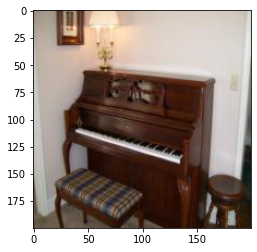

In [24]:
plt.imshow(filename_image_dict.get('yolo_example/train/2aace487f850a4a3.jpeg'))

### Define, Compile, and Fit Model

In [38]:
from keras.optimizers import Optimizer
import keras.backend as K

class AccumOptimizer(Optimizer):
    """Inheriting Optimizer class, wrapping the original optimizer
    to achieve a new corresponding optimizer of gradient accumulation.
    # Arguments
        optimizer: an instance of keras optimizer (supporting
                    all keras optimizers currently available);
        steps_per_update: the steps of gradient accumulation
    # Returns
        a new keras optimizer.
    """
    def __init__(self, optimizer, steps_per_update=1, **kwargs):
        super(AccumOptimizer, self).__init__(name = 'AccumOptimizer', **kwargs)
        self.optimizer = optimizer
        with K.name_scope(self.__class__.__name__):
            self.steps_per_update = steps_per_update
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.cond = K.equal(self.iterations % self.steps_per_update, 0)
            self.lr = self.optimizer.lr
            self.optimizer.lr = K.switch(self.cond, self.optimizer.lr, 0.)
            for attr in ['momentum', 'rho', 'beta_1', 'beta_2']:
                if hasattr(self.optimizer, attr):
                    value = getattr(self.optimizer, attr)
                    setattr(self, attr, value)
                    setattr(self.optimizer, attr, K.switch(self.cond, value, 1 - 1e-7))
            for attr in self.optimizer.get_config():
                if not hasattr(self, attr):
                    value = getattr(self.optimizer, attr)
                    setattr(self, attr, value)
            # Cover the original get_gradients method with accumulative gradients.
            def get_gradients(loss, params):
                return [ag / self.steps_per_update for ag in self.accum_grads]
            self.optimizer.get_gradients = get_gradients
    def get_updates(self, loss, params):
        self.updates = [
            K.update_add(self.iterations, 1),
            K.update_add(self.optimizer.iterations, K.cast(self.cond, 'int64')),
        ]
        # gradient accumulation
        self.accum_grads = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        grads = self.get_gradients(loss, params)
        for g, ag in zip(grads, self.accum_grads):
            self.updates.append(K.update(ag, K.switch(self.cond, ag * 0, ag + g)))
        # inheriting updates of original optimizer
        self.updates.extend(self.optimizer.get_updates(loss, params)[1:])
        self.weights.extend(self.optimizer.weights)
        return self.updates
    def get_config(self):
        iterations = K.eval(self.iterations)
        K.set_value(self.iterations, 0)
        config = self.optimizer.get_config()
        K.set_value(self.iterations, iterations)
        return config

In [43]:
keras.backend.clear_session()
# Define Model
yolo_model = yolo_noskip_convnet()
#yolo_model = yolo_reorg_convnet()
#optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = AccumOptimizer(Adam(), 50)
optimizer = Adam()
yolo_model.compile(loss=custom_loss, optimizer=optimizer)
yolo_model.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,128,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [30]:
# Generator Object
#train_batch_generator = SimpleBatchGenerator(train_image, generator_config, norm=normalize, shuffle=True)
#train_batch_generator = SimpleBatchGenerator(train_images_success, generator_config, shuffle=True)
#train_batch_generator = SimpleBatchGenerator(train_images_success, generator_config, shuffle=True)
train_batch_generator = SimpleBatchGeneratorLoaded(images = train_images_success,
                                                   filename_image_dict = filename_image_dict,
                                                   config = generator_config,
                                                   shuffle=True)

# Model Callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',  min_delta = 0.001, patience = 3,  mode='min',  verbose=1)

checkpoint = keras.callbacks.ModelCheckpoint(f'{model_save_path}{model_save_name}', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# Fit Model
tf.config.run_functions_eagerly(True)

yolo_model.fit(train_batch_generator, 
               steps_per_epoch  = len(train_batch_generator),
               epochs = 5, 
               verbose = 1,
               callbacks = [early_stop, checkpoint])

Epoch 1/5
 70/881 [=>............................] - ETA: 5:52 - loss: 0.0000e+00

ResourceExhaustedError: OOM when allocating tensor with shape[4,128,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:FusedBatchNormV3]

In [ ]:
# Things to Try
# gradient accumulation